In [1]:
using QuadGK,LaTeXStrings,LinearAlgebra,BenchmarkTools;
using Plots;
import NLsolve,Roots;
import Optim;
pyplot(frame=:box, minorticks=5, size=(500,350), fontfamily="serif",titlefontsize=11
    ,guidefontsize=12,tickfontsize=11,legendfontsize=9,
    bg_color_legend = RGBA(1,1,1,0.15), markerstrokecolor= :auto);

In [2]:
include("./libs/constants.jl");
include("./libs/pwa.jl");
include("./libs/potentials.jl");

In [3]:
function potential_Xn(E, p, q, pon, qon; C=1, a=0, a1=0.0, isπ=true)
    q01, q02 = q0f(E, mDn, mDsn, mDn, mDsn), q0f(E, mDn, mDsn, mDsn, mDn)
    res = zero(ComplexF64)

#     if isπ == true
#         res += (-C) * (√2 * g / fπ)^2 / 4 * pwa_tensor_ss_deform(p, q, mπn^2 - q02^2; a=a1)
#     end
    res += (-C) * 1 / 3 * (√2 * g / fπ)^2 / 4 * pwa_tensor_ss(pon, qon, mη^2 - q02^2; a=a)
    res += -β^2 * gV^2 * (1 - q01^2 / mρn^2) / 4 * pwa_central(p, q, mρn^2 - q01^2)
    res += (-C) * (2 * gλ * gV)^2 / 4 * pwa_vvv_ss(pon, qon, mρn^2 - q02^2; a=a)
    res += -β^2 * gV^2 * (1 - q01^2 / mω^2) / 4 * pwa_central(p, q, mω^2 - q01^2)
    res += (-C) * (2 * gλ * gV)^2 / 4 * pwa_vvv_ss(pon, qon, mω^2 - q02^2; a=a)
    res += -4 * gs^2 / 4 * pwa_central(p, q, mσ^2 - q01^2)
    #J/ψ
    res += -β^2 * gV^2 * (1 - q01^2 / mJψ^2) / 4 * pwa_central(p, q, mJψ^2 - q01^2) * 2
    res += (-C) * (2 * gλ * gV)^2 / 4 * pwa_vvv_ss(pon, qon, mJψ^2 - q02^2; a=a) * 2
#     ηc
    res += (-C) * (√2 * g / fπ)^2 / 4 * pwa_tensor_ss(pon, qon, mηc^2 - q02^2; a=a) * 2
    return res
end

function potential_Xc(E, p, q, pon, qon; C=1, a=0, a1=0.0, isπ=true)
    q01, q02 = q0f(E, mDc, mDsc, mDc, mDsc), q0f(E, mDc, mDsc, mDsc, mDc)
    res = zero(ComplexF64)

#     if isπ == true
#         res += (-C) * (√2 * g / fπ)^2 / 4 * pwa_tensor_ss_deform(p, q, mπn^2 - q02^2; a=a1)
#     end
    res += (-C) * 1 / 3 * (√2 * g / fπ)^2 / 4 * pwa_tensor_ss(pon, qon, mη^2 - q02^2; a=a)
    res += -β^2 * gV^2 * (1 - q01^2 / mρn^2) / 4 * pwa_central(p, q, mρn^2 - q01^2)
    res += (-C) * (2 * gλ * gV)^2 / 4 * pwa_vvv_ss(pon, qon, mρn^2 - q02^2; a=a)
    res += -β^2 * gV^2 * (1 - q01^2 / mω^2) / 4 * pwa_central(p, q, mω^2 - q01^2)
    res += (-C) * (2 * gλ * gV)^2 / 4 * pwa_vvv_ss(pon, qon, mω^2 - q02^2; a=a)
    res += -4 * gs^2 / 4 * pwa_central(p, q, mσ^2 - q01^2)
    #J/ψ
    res += -β^2 * gV^2 * (1 - q01^2 / mJψ^2) / 4 * pwa_central(p, q, mJψ^2 - q01^2) * 2
    res += (-C) * (2 * gλ * gV)^2 / 4 * pwa_vvv_ss(pon, qon, mJψ^2 - q02^2; a=a) * 2
#     #ηc
    res += (-C) * (√2 * g / fπ)^2 / 4 * pwa_tensor_ss(pon, qon, mηc^2 - q02^2; a=a) * 2

    return res
end

function potential_Xcross(E, p, q, pon, qon; C=1, a=0, a1=0.0, isπ=true)
    q01, q02 = q0f(E, mDn, mDsn, mDc, mDsc), q0f(E, mDn, mDsn, mDsc, mDc)
    res = zero(ComplexF64)

    res += -(√2 * gV * β)^2 * (1 - q01^2 / mρc^2) / 4 * pwa_central(p, q, mρc^2 - q01^2)
    res += (-C) * (2 * √2 * gλ * gV)^2 / 4 * pwa_vvv_ss(pon, qon, mρc^2 - q02^2; a=a)
#     if isπ == true
#         res += (-C) * (2 * g / fπ)^2 / 4 * pwa_tensor_ss(p, q, mπc^2 - q02^2; a=a1)
#     end
    return res
end

potential_Xcross (generic function with 1 method)

In [4]:
λf(x, y, z) = x^2 + y^2 + z^2 - 2 * x * y - 2 * x * z - 2 * y * z
q0f(E, m1, m2, m3, m4) = abs(m3^2 - m4^2 - m1^2 + m2^2) / (2 * E)
μf(m1, m2) = m1 * m2 / (m1 + m2)

# redefine sqrt so that its cut is along the positive x axis
function xsqrt(x)
    imag(x) >=0 ? sqrt(x+0im) : -sqrt(x-0im)
end
xsqrt1(x)= (imag(x)<0&&real(x)>0) ? -xsqrt(x) : xsqrt(x)

xsqrt1 (generic function with 1 method)

In [5]:
qon_0(E)=xsqrt(2*μf(mDn,mDsn)*(E-mDn-mDsn))
qon_c(E)=xsqrt(2*μf(mDc,mDsc)*(E-mDc-mDsc))

qon_c (generic function with 1 method)

In [6]:
xxx,www=gauss(96,0,1);

qi=zeros(ComplexF64,2+length(xxx));
wi=zeros(ComplexF64,length(xxx));
len=length(xxx);
sublen=length(qi);

In [7]:
Γsmc(t,Λ,ω,V0)=t+im*V0*(1-exp(-t/ω))*(1-exp((t-Λ)/ω))
dΓsmc(t,Λ,ω,V0)=1+im*V0/ω*(exp(-t/ω)-exp((t-Λ)/ω))
Γsmcx(x,Λ,ω,V0)=Γsmc(Λ*x,Λ,ω,V0) #0~x~1
dΓsmcx(x,Λ,ω,V0)=Λ*dΓsmc(Λ*x,Λ,ω,V0)

dΓsmcx (generic function with 1 method)

# VGT

In [8]:
function getqw(E,Λ;rs=1,ω=0.1,V0=0.0,qi=qi,wi=wi)
    qi[1],qi[2]=qon_0(E)*(-1)^(rs+1),qon_c(E)
    for i in eachindex(xxx)
        qi[2+i]=Γsmcx(xxx[i],Λ,ω,V0)
        wi[i]=dΓsmcx(xxx[i],Λ,ω,V0)*www[i]
    end
    nothing
end

getqw (generic function with 1 method)

In [9]:
getqw(mDn+mDsn-40e-6,0.6;rs=1)

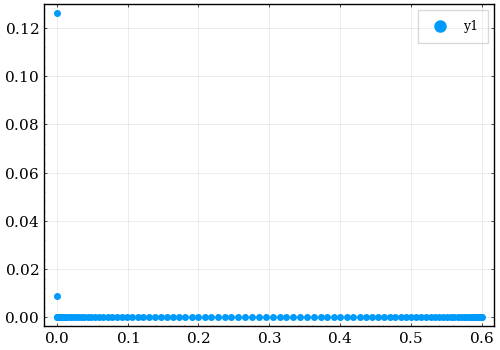

In [10]:
scatter(real.(qi[1:end]),imag.(qi[1:end]))

In [11]:
Vmat=zeros(ComplexF64,2*length(qi),2*length(qi));
Gmat=zeros(ComplexF64,2*length(qi),2*length(qi));
Tmat=zeros(ComplexF64,2*length(qi),2*length(qi));

In [12]:
function VMat!(E;Λ=0.5,C=1,a = 0.0,a1=0.0,isπ=false,plist=qi,des=Vmat,kwds...)
    getqw(E,Λ;kwds...)
    k1,k2=plist[1],plist[2]

    for l in eachindex(plist)
        for m in eachindex(plist)
            i, j = 1, 1
            des[sublen*(i-1)+l, sublen*(j-1)+m] = potential_Xn(E,plist[l], plist[m],k1,k1;C=C,a = a,a1=a1,isπ=isπ)
            i, j = 1, 2
            des[sublen*(i-1)+l, sublen*(j-1)+m] = potential_Xcross(E,plist[l], plist[m],k2,k1;C=C,a = a,a1=a1,isπ=isπ)
            i, j = 2, 1
            des[sublen*(i-1)+l, sublen*(j-1)+m] = potential_Xcross(E,plist[l], plist[m],k1,k2; C=C,a = a,a1=a1,isπ=isπ)
            i, j = 2, 2
            des[sublen*(i-1)+l, sublen*(j-1)+m] = potential_Xc(E,plist[l], plist[m],k2,k2;C=C,a = a,a1=a1,isπ=isπ)
        end
    end
    return nothing
end

VMat! (generic function with 1 method)

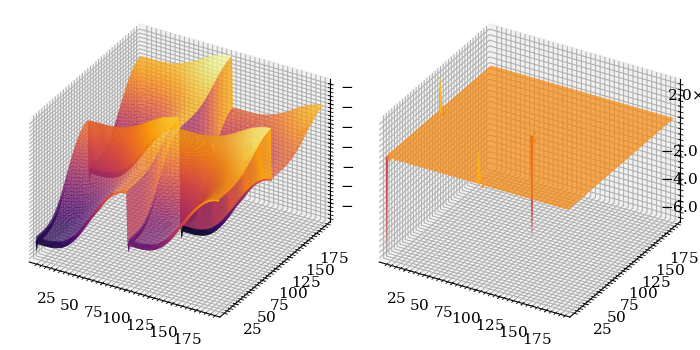

In [13]:
VMat!(3.87165;isπ=false)
plot(surface(collect(1:2*length(qi)),collect(1:2*length(qi)),[real(Vmat[x,y]) for y in 1:2*length(qi),x in 1:2*length(qi)],legend=false),
surface(collect(1:2*length(qi)),collect(1:2*length(qi)),[imag(Vmat[x,y]) for y in 1:2*length(qi),x in 1:2*length(qi)],legend=false),layout=(1,2),size=(700,350))

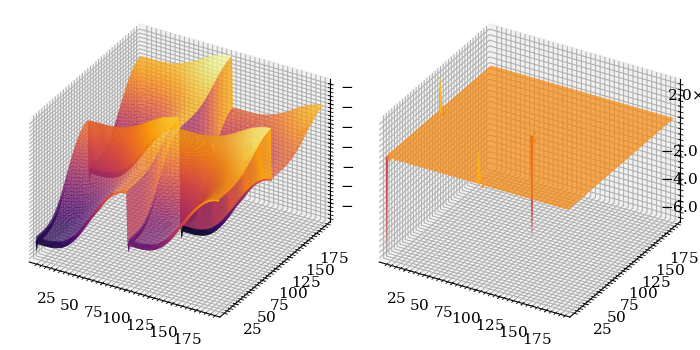

In [14]:
VMat!(3.87165;isπ=true)
plot(surface(collect(1:2*length(qi)),collect(1:2*length(qi)),[real(Vmat[x,y]) for y in 1:2*length(qi),x in 1:2*length(qi)],legend=false),
surface(collect(1:2*length(qi)),collect(1:2*length(qi)),[imag(Vmat[x,y]) for y in 1:2*length(qi),x in 1:2*length(qi)],legend=false),layout=(1,2),size=(700,350))

In [15]:
Gc(E,q)=1/(2π^2)/(E-mDc-mDsc-q^2/(2*μf(mDc,mDsc)))
Gn(E,q)=1/(2π^2)/(E-mDn-mDsn-q^2/(2*μf(mDn,mDsn)))

Gn (generic function with 1 method)

In [16]:
function GMat!(E;Λ=0.5,qi=qi,wi=wi,des=Gmat)
    getqw(E,Λ)
    
    i=1
    for j in eachindex(wi)
        des[(i-1)*sublen+2+j,(i-1)*sublen+2+j]=wi[j]*qi[2+j]^2*Gn(E,qi[2+j])
    end
    
    i=2
    for j in eachindex(wi)
        des[(i-1)*sublen+2+j,(i-1)*sublen+2+j]=wi[j]*qi[2+j]^2*Gc(E,qi[2+j])
    end
    
    return nothing
end

GMat! (generic function with 1 method)

In [17]:
function detVG(E;rs=1,Λ=0.5,a = 0.0,a1=0.0,C=1,isπ=false)
    VMat!(E;rs=rs,Λ=Λ,a=a,a1=a1,C=C,isπ=isπ)
    GMat!(E;Λ=Λ)
    return det(LinearAlgebra.I-Vmat*Gmat)
end

detVG (generic function with 1 method)

In [18]:
function TMat!(E;rs=1,Λ=0.5,a = 0.0,a1=0.0,C=1,des=Tmat,isπ=false)
    VMat!(E;rs=rs,Λ=Λ,a=a,a1=a1,C=C,isπ=isπ)
    GMat!(E;Λ=Λ)
    des .=inv(LinearAlgebra.I-Vmat*Gmat)*Vmat
    nothing
end

TMat! (generic function with 1 method)

In [19]:
@btime TMat!(3.87165)

  9.497 ms (2521 allocations: 2.59 MiB)


# Extract pole position

## C=+

In [19]:
function find_poles(pars;C=1)
    _lam,_a1=pars
    function f!(F, x)
        e, γ = x
        tmp = detVG(e + im * γ;C=C, Λ = _lam,a1=_a1)
        F[1] = real(tmp)
        F[2] = imag(tmp)
    end
    tmp=NLsolve.nlsolve((F, x) -> f!(F, x), [mDn + mDsn - 40e-6, 0])
#     println((tmp.zero[1]-mDn-mDsn)+im*tmp.zero[2])
#     tmp
    (tmp.zero[1]-mDn-mDsn)+im*tmp.zero[2]
end

find_poles (generic function with 1 method)

In [20]:
find_poles([0.35,1.0])

-0.0009096404209274489 + 0.0im

In [25]:
find_poles([0.9,1.0])

0.1128275635604461 - 9.414365129201505e-20im

In [22]:
# Roots.find_zero(λ->real(find_poles([λ,1.0]))+40e-6,(0.3,2.0))

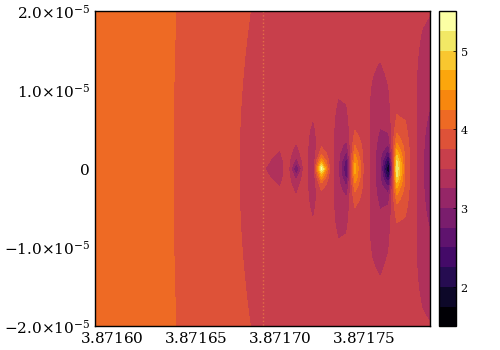

In [28]:
let Ev=collect(mDn+mDsn-100e-6:5e-6:mDn+mDsn+100e-6),Γv=collect(-20e-6:1e-6:20e-6)
    resv=[1/abs(detVG(e+im*γ;Λ=0.4,a1=1.0)) for γ in Γv,e in Ev]
    contour(Ev,Γv,resv,fill=true)
    vline!([mDn+mDsn],ls=:dot,label=false)
end

## C=-

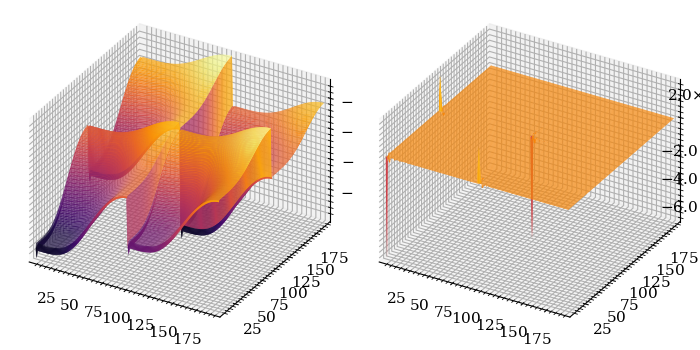

In [37]:
VMat!(3.87165;C=-1,isπ=false)
plot(surface(collect(1:2*length(qi)),collect(1:2*length(qi)),[real(Vmat[x,y]) for y in 1:2*length(qi),x in 1:2*length(qi)],legend=false),
surface(collect(1:2*length(qi)),collect(1:2*length(qi)),[imag(Vmat[x,y]) for y in 1:2*length(qi),x in 1:2*length(qi)],legend=false),layout=(1,2),size=(700,350))

In [23]:
find_poles([0.73,1.0];C=-1)

-0.02754923701458223 - 0.0009980022050850882im


Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [3.8716500000000003, 0.0]
 * Zero: [3.844140762985418, -0.0009980022050850882]
 * Inf-norm of residuals: 0.000000
 * Iterations: 16
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 14
 * Jacobian Calls (df/dx): 12

In [38]:
Roots.find_zero(λ->real(find_poles([λ,1.0];C=-1))+40e-6,(0.3,0.4))

0.3178769637397383

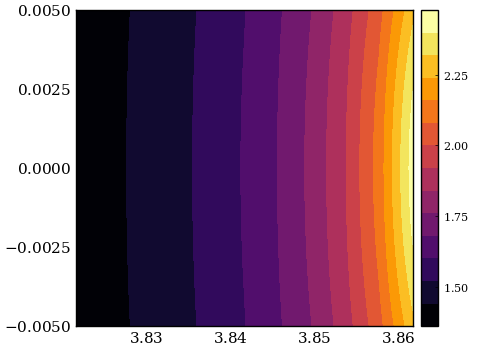

In [39]:
let Ev=collect(mDn+mDsn-50e-3:4e-3:mDn+mDsn-10e-3),Γv=collect(-5e-3:5e-4:5e-3)
    resv=[1/abs(detVG(e+im*γ;C=-1,Λ=0.3178769637397383,a1=1.0)) for γ in Γv,e in Ev]
    contour(Ev,Γv,resv,fill=true)
end

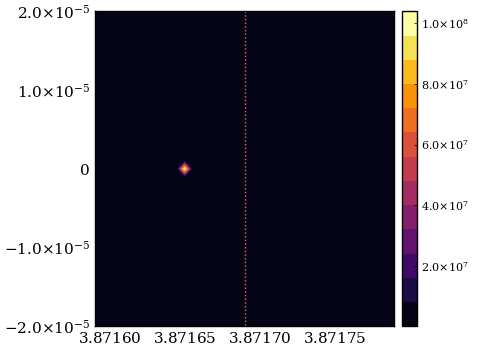

In [40]:
let Ev=collect(mDn+mDsn-100e-6:5e-6:mDn+mDsn+100e-6),Γv=collect(-20e-6:1e-6:20e-6)
    resv=[1/abs(detVG(e+im*γ;C=-1,Λ=0.3178769637397383,a1=1.0)) for γ in Γv,e in Ev]
    contour(Ev,Γv,resv,fill=true)
    vline!([mDn+mDsn],ls=:dot,label=false)
end

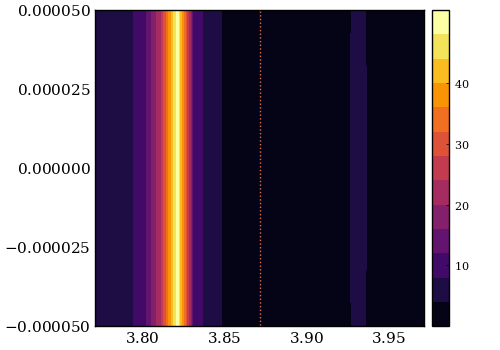

In [44]:
let Ev=collect(mDn+mDsn-100e-3:10e-3:mDn+mDsn+100e-3),Γv=collect(-50e-6:5e-6:50e-6)
    resv=[1/abs(detVG(e+im*γ;C=1,Λ=0.73,a1=1.0)) for γ in Γv,e in Ev]
    contour(Ev,Γv,resv,fill=true)
    vline!([mDn+mDsn],ls=:dot,label=false)
end

In [46]:
3.8726-mDn-mDsn

0.0009099999999997443